## Import packages

In [4]:
#!pip install imgaug
#!pip install opencv-python
#!pip install --upgrade scikit-image

In [1]:
import os, sys, warnings, random, tqdm, glob, pylab, numpy as np, pandas as pd
import pydicom, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches


import cv2
from sklearn.model_selection import KFold
from PIL import Image

### Setting

In [2]:
pd.set_option('display.max_columns',50)
warnings.filterwarnings("ignore")

In [110]:
os.chdir('/home/ubuntu/healthcare/pneumonia_lungfish/')
# Directory to save logs and trained model
src = '/home/ubuntu/healthcare/pneumonia_lungfish/src'
MASK_RCNN = '/home/ubuntu/healthcare/pneumonia_lungfish/src/Mask_RCNN'
models_working_DIR = '/home/ubuntu/healthcare/pneumonia_lungfish/src/models_working'
COCO_WEIGHTS_PATH = "/home/ubuntu/healthcare/pneumonia_lungfish/src/Mask_RCNN_coco_weights/mask_rcnn_coco.h5"


raw_data_DIR = '/home/ubuntu/healthcare/pneumonia_lungfish/src/data/raw'
procesed_data_DIR = '/home/ubuntu/healthcare/pneumonia_lungfish/src/data/processed'
train_dicom_dir = '/home/ubuntu/healthcare/pneumonia_lungfish/src/data/raw/stage_2_train_images/'


#delete below old path
#work_DIR = '/home/ubuntu/healthcare/pneumonia_lungfish/models/working'
#train_DIR = "data/raw/stage_2_train_images/"


## 1. EDA

In [4]:
train_labels = pd.read_csv(os.path.join(raw_data_DIR,'stage_2_train_labels.csv'))
train_info = pd.read_csv(os.path.join(raw_data_DIR,'stage_2_detailed_class_info.csv'))
print(train_labels.head(2))
print(train_info.head(2))

                              patientId   x   y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6 NaN NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd NaN NaN    NaN     NaN       0
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal


### Merge 1: train_labels and train_infor by joining on 'patientId'

In [5]:
df_merge = pd.merge(train_labels,train_info, on='patientId',how='left')
print(df_merge.head())


                              patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity  


In [6]:
df_merge.to_csv(os.path.join(procesed_data_DIR,'df_train_labels_infor_merge.csv'), index = False)

###  What are the data fields?

The training data is provided as a set of patientIds and bounding boxes. 
  * x_ - the upper-left x coordinate of the bounding box.
  * y_ - the upper-left y coordinate of the bounding box.
  * width_ - the width of the bounding box.
  * height_ - the height of the bounding box.


patientId _- A patientId. Each patientId corresponds to a unique image.
Target_ - the binary Target, indicating whether this sample has evidence of pneumonia.

* For Target =1, pneumonia, there is x, y, width, and height 
* For Target = 0, non-pneumonia, these cells are blank



### 2. Remove replicates


In [7]:
print(df_merge.info())
df_dropdup = df_merge.drop_duplicates()
print(df_dropdup.info())

df_dropdup.to_csv(os.path.join(procesed_data_DIR, 'df_train_labels_infor_merge.csv'), index = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37629 entries, 0 to 37628
Data columns (total 7 columns):
patientId    37629 non-null object
x            16957 non-null float64
y            16957 non-null float64
width        16957 non-null float64
height       16957 non-null float64
Target       37629 non-null int64
class        37629 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 2.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37627
Data columns (total 7 columns):
patientId    30227 non-null object
x            9555 non-null float64
y            9555 non-null float64
width        9555 non-null float64
height       9555 non-null float64
Target       30227 non-null int64
class        30227 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB
None


### Yes, There are 7402 replicates in the train_label or train_info csv files
### *Check later:** are there replicates in the image folder???*

In [8]:
df_dropdup.groupby(['class', 'Target']).size().reset_index(name=' Count')

,class,Target,Count
0,Lung Opacity,1,9555
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


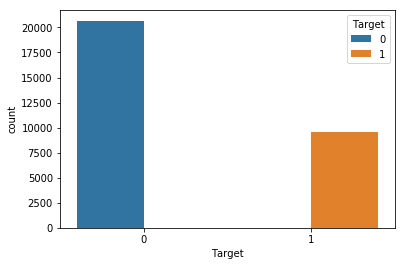

In [9]:
# Count plot, x Target, color is target
sns.countplot(x = 'Target', hue = 'Target', data = df_dropdup)

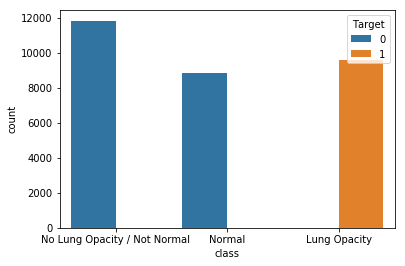

In [10]:
sns.countplot(x = 'class', hue = 'Target', data = df_dropdup)

### Are there multiple images for one patient? yes

In [11]:

print(df_dropdup['patientId'].value_counts().unique())

#Group by patientId and count
print(df_dropdup['patientId'].value_counts().value_counts())

# check the head
print(df_dropdup['patientId'].value_counts().head(5))


[4 3 2 1]
1    23286
2     3266
3      119
4       13
Name: patientId, dtype: int64
8dc8e54b-5b05-4dac-80b9-fa48878621e2    4
ee820aa5-4804-4984-97b3-f0a71d69702f    4
32408669-c137-4e8d-bd62-fe8345b40e73    4
1c44e0a4-4612-438f-9a83-8d5bf919cb67    4
3239951b-6211-4290-b237-3d9ad17176db    4
Name: patientId, dtype: int64


### 3: Merge with box counts

Yes. These are the number of bounding boxes for patients?

In [12]:
box_counts = df_dropdup.groupby(['patientId','Target'])\
.size()\
.sort_values(ascending=False)\
.reset_index(name='boxes')
box_counts.head(2)

,patientId,Target,boxes
0,7d674c82-5501-4730-92c5-d241fd6911e7,1,4
1,31764d54-ea3b-434f-bae2-8c579ed13799,1,4


In [13]:
df_box = pd.merge(df_dropdup, box_counts, on = 'patientId',how='left')
df_box.head()

df_box.to_csv(os.path.join(procesed_data_DIR, 'df_train_labels_infor_boxes_merge.csv'), index = False)

### 4. Summary of box count

In [14]:
box_count_sum = df_box.\
    groupby('boxes').\
    size().\
    reset_index(name='patients')

box_count_sum.to_csv(os.path.join(procesed_data_DIR,'df_boxe_count_sum.csv'), index = False)

Yes. Target =1 group can have more than 1 picture. **Why? ** 

### 4. The size of boxes 

In [15]:
df_box['x_2'] = df_box['x'] + df_box['width']
df_box['y_2'] = df_box['y'] + df_box['height']
df_box['x_center'] = df_box['x'] + df_box['width'] / 2
df_box['y_center'] = df_box['y'] + df_box['height'] / 2
df_box['area'] = df_box['width'] * df_box['height']

print(df_box.head())

                              patientId      x      y  width  height  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   

   Target_x                         class  Target_y  boxes    x_2    y_2  \
0         0  No Lung Opacity / Not Normal         0      1    NaN    NaN   
1         0  No Lung Opacity / Not Normal         0      1    NaN    NaN   
2         0  No Lung Opacity / Not Normal         0      1    NaN    NaN   
3         0                        Normal         0      1    NaN    NaN   
4         1                  Lung Opacity         1      2  477.0  531.0   

   x_center  y_center     area  
0       NaN       NaN      NaN  
1       NaN       NaN      NaN  
2       NaN

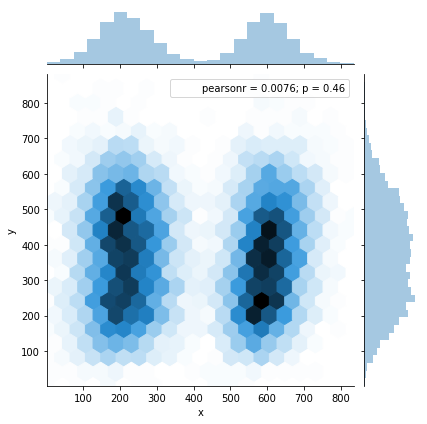

In [16]:
# What are the upper boundaries of bounding boxes?
sns.jointplot(x = 'x', y = 'y', data = df_box,kind ='hex', gridsize = 20)

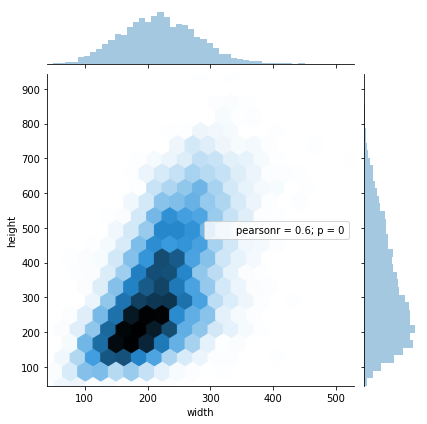

In [17]:
# How big are the bounding boxes?
sns.jointplot(x = 'width', y = 'height', data = df_box,kind ='hex', gridsize = 20)

## II Image Part 

### How does a pneumonia DICOM image look like?

In [18]:

train_dicom = [f for f in os.listdir(train_dicom_dir) if os.path.isfile(os.path.join(train_dicom_dir, f))]

print(train_dicom[:1])


['79d6e398-6ee6-4c5a-b924-a082d3c1cce9.dcm']


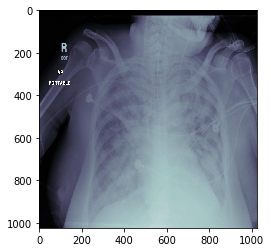

In [19]:
# check an image with 4 boxes 
# 7d674c82-5501-4730-92c5-d241fd6911e7
#doc
file = pydicom.read_file(os.path.join(train_dicom_dir,'7d674c82-5501-4730-92c5-d241fd6911e7.dcm'))
plt.imshow(file.pixel_array, cmap=plt.cm.bone) 

## Add bounding boxes 

In [20]:
df_box[df_box['patientId'].str.match('7d674c82-5501-4730-92c5-d241fd6911e7')]

,patientId,x,y,width,height,Target_x,class,Target_y,boxes,x_2,y_2,x_center,y_center,area
12251,7d674c82-5501-4730-92c5-d241fd6911e7,358.0,320.0,159.0,186.0,1,Lung Opacity,1,4,517.0,506.0,437.5,413.0,29574.0
12252,7d674c82-5501-4730-92c5-d241fd6911e7,283.0,528.0,197.0,314.0,1,Lung Opacity,1,4,480.0,842.0,381.5,685.0,61858.0
12253,7d674c82-5501-4730-92c5-d241fd6911e7,718.0,573.0,133.0,227.0,1,Lung Opacity,1,4,851.0,800.0,784.5,686.5,30191.0
12254,7d674c82-5501-4730-92c5-d241fd6911e7,658.0,315.0,164.0,203.0,1,Lung Opacity,1,4,822.0,518.0,740.0,416.5,33292.0


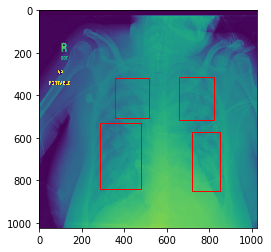

In [21]:

im = file.pixel_array
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect1 = patches.Rectangle((358,320),159,186,linewidth=1,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((283,528),197,314,linewidth=1,edgecolor='r',facecolor='none')
rect3 = patches.Rectangle((718,573),133,277,linewidth=1,edgecolor='r',facecolor='none')
rect4 = patches.Rectangle((658,315),164,203,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)
plt.show()

## Sample sheet

In [22]:
sample = pd.read_csv(os.path.join(procesed_data_DIR,'sample_df_table.csv'))
sample.head()

,patientId,x,y,width,height,Target_x,class,Target_y,boxes,path
0,c70d9bf5-764d-4e5c-b8bb-cbad489d3f2c,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,1,/Users/j/Dropbox/Learn/lung_pneumonia/data/raw...
1,8e9da305-fc8f-4d6a-ba83-42c8bede571d,NaN,NaN,NaN,NaN,0,Normal,0,1,/Users/j/Dropbox/Learn/lung_pneumonia/data/raw...
2,1fd92186-f1fa-477d-b23e-abfd7ad537ce,222.0,595.0,148.0,200.0,1,Lung Opacity,1,1,/Users/j/Dropbox/Learn/lung_pneumonia/data/raw...
3,84909dca-4b86-43dd-8bba-d8fc06a85e15,266.0,100.0,245.0,563.0,1,Lung Opacity,1,2,/Users/j/Dropbox/Learn/lung_pneumonia/data/raw...
4,84909dca-4b86-43dd-8bba-d8fc06a85e15,599.0,416.0,265.0,281.0,1,Lung Opacity,1,2,/Users/j/Dropbox/Learn/lung_pneumonia/data/raw...


In [23]:
sample_demo= sample[['patientId','class','Target_x']]

sample_demo['Gender'] = ''
sample_demo['age'] =''
sample_demo['size'] =''

sample_demo.head()

,patientId,class,Target_x,Gender,age,size
0,c70d9bf5-764d-4e5c-b8bb-cbad489d3f2c,No Lung Opacity / Not Normal,0,,,
1,8e9da305-fc8f-4d6a-ba83-42c8bede571d,Normal,0,,,
2,1fd92186-f1fa-477d-b23e-abfd7ad537ce,Lung Opacity,1,,,
3,84909dca-4b86-43dd-8bba-d8fc06a85e15,Lung Opacity,1,,,
4,84909dca-4b86-43dd-8bba-d8fc06a85e15,Lung Opacity,1,,,


## Let's check a negative case 

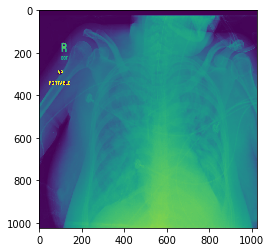

In [24]:
#doc
neg = pydicom.read_file(os.path.join(train_dicom_dir,'4ba3e640-eb0a-4f4f-900c-af7405bc1790.dcm'))
#plt.imshow(file.pixel_array, cmap=plt.cm.bone) 
df_dropdup[df_dropdup['patientId'].str.match('4ba3e640-eb0a-4f4f-900c-af7405bc1790')]

im2 = neg.pixel_array
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
# Add the patch to the Axes

plt.show()

# Model

## Transfer learning using MASK_RCNN  

os.chdir('/home/ubuntu/healthcare/pneumonia_lungfish/src/')  
!git clone https://www.github.com/matterport/Mask_RCNN.git  
sys.path.append(os.path.join(src, 'Mask_RCNN'))  
os.chdir('Mask_RCNN/')  
!python setup.py -q install

In [83]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Some setup functions and classes for Mask-RCNN
* dicom_fps is a list of the dicom image path and filenames
* image_annotions is a dictionary of the annotations keyed by the filenames
* parsing the dataset returns a list of the image filenames and the annotations dictionary


In [84]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm') #a list of the dicom image path and filenames
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps} #a dictionary of the annotations keyed by the filenames
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId'] + '.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [85]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [86]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target_x'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)
    #Target_x and Target_y are the same as Target

### Match training csv and images 

In [89]:
# training dataset
df_box = pd.read_csv(os.path.join(procesed_data_DIR,'df_train_labels_infor_boxes_merge.csv'))
df_box.head(2)

,patientId,x,y,width,height,Target_x,class,Target_y,boxes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0,1


In [90]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=df_box)

### Split the dataset into train and validation 

In [91]:
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)


val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))
#print(image_fps_val[:5])

25184 1500


In [92]:
# prepare the training dataset
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024


dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    a0829514-1a9a-4abf-92df-eb4229c69ef5
 x                                             NaN
 y                                             NaN
 width                                         NaN
 height                                        NaN
 Target_x                                        0
 class                No Lung Opacity / Not Normal
 Target_y                                        0
 boxes                                           1
 Name: 16607, dtype: object]

In [93]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

(1024, 1024, 3)
/home/ubuntu/healthcare/pneumonia_lungfish/src/data/raw/stage_2_train_images/c3a9ec26-c2c0-4c78-b52e-ed023bf16b3d.dcm
[1 1]


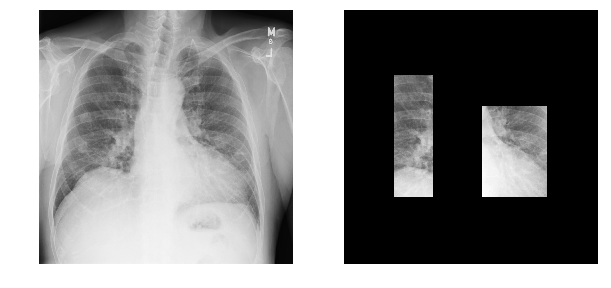

In [98]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [109]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=models_working_DIR)

# Exclude the last layers because they require a matching

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

In [116]:
LEARNING_RATE = 0.006


In [117]:
%%time

## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=1,
            layers='heads',
            augmentation=None)  ## no augmentation



Starting at epoch 0. LR=0.012

Checkpoint Path: /home/ubuntu/healthcare/pneumonia_lungfish/src/models_working/pneumonia20190301T1557/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask

In [118]:
history = model.keras_model.history.history

In [119]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,loss,mrcnn_bbox_loss,mrcnn_class_loss,mrcnn_mask_loss,rpn_bbox_loss,rpn_class_loss,val_loss,val_mrcnn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_mask_loss,val_rpn_bbox_loss,val_rpn_class_loss
1,1.704588,0.452274,0.225689,0.398052,0.607719,0.020851,1.900809,0.577757,0.356559,0.411979,0.537753,0.016758


model.get_trainable_layers()# 71 layers

In [ ]:
plt.figure(figsize=(50,12))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()


### Selecte best epoch 

In [39]:
best_epoch = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch + 1, history["val_loss"][best_epoch])

Best Epoch: 2 nan


### Select trained model 

In [43]:
model.model_dir

'/home/ubuntu/healthcare/pneumonia_lungfish/models'

In [ ]:
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Reference 
https://colab.research.google.com/github/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-kaggle.ipynb#scrollTo=8EBVA1M60yAj

https://www.kaggle.com/hmendonca/mask-rcnn-and-coco-transfer-learning-lb-0-155

## Error